In [2]:
import sqlalchemy as sa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display
import datetime

## Dependencies to manipulate Control Variables
import os
from dotenv import dotenv_values

ENV_FILE='.env' # <- CHANGE THIS TO PLOT YOUR CONFIGURATION

dotenv_path = os.path.join('.env')
config = dotenv_values(dotenv_path)

# Control Values
DB_HOST=config['DB_HOST']
DB_PORT=config['DB_PORT']
DB_NAME=config['DB_NAME']
DB_USER=config['DB_USER']
DB_PASSWD=config['DB_PASSWD']
FIGS_FOLDER=config['FIGS_FOLDER']
## SQL queries related stuff
START_DATE=datetime.datetime.strptime(config['START_DATE'], '%Y-%m-%d')
FINISH_DATE=datetime.datetime.strptime(config['FINISH_DATE'], '%Y-%m-%d')
# Configure the main plotting configuration
## Plot related configurations
FIG_SIZE=(10,6)
sns.set_context("talk", font_scale=1)

## DB Credentials
print(
    f'connecting to database "{DB_NAME}" at "{DB_HOST}"\n',
    f'keeping plots at "{FIGS_FOLDER}"'
)

engine = sa.create_engine(
    f'postgresql://{DB_USER}:{DB_PASSWD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
con = engine.connect()

connecting to database "hoarder_prod" at "ec2-3-66-188-202.eu-central-1.compute.amazonaws.com"
 keeping plots at "./pics/"


total cids: 125589


success_att
prov_op                          
std-dht-provide 0.90         20.0
                0.50         17.0
                0.01         12.0

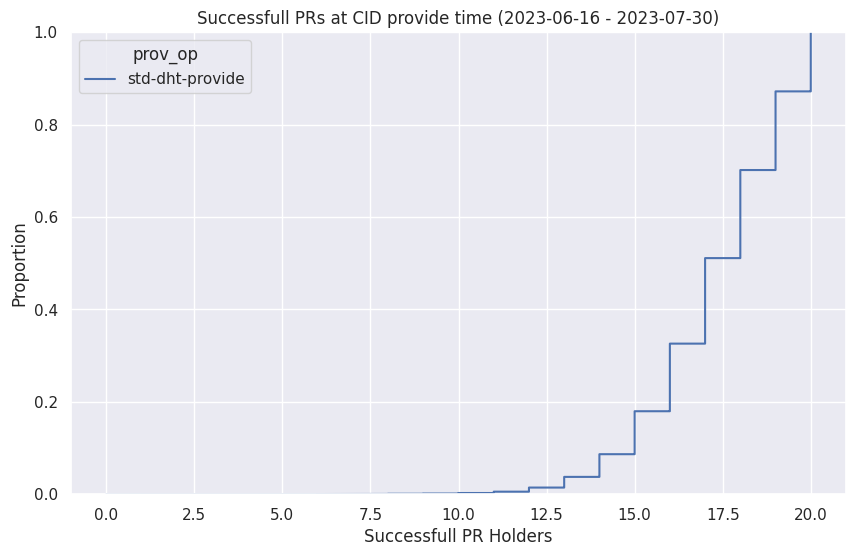

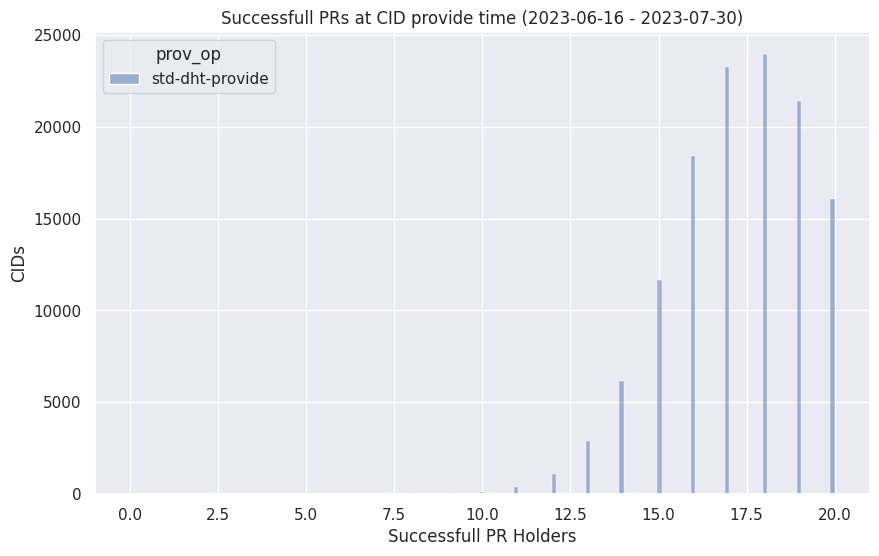

In [11]:
# Successfull peers on Publication
## SQL Query
query = f"""
    SELECT
        prov_op,
        success_att
    FROM fetch_results
    INNER JOIN cid_info ON fetch_results.cid_hash = cid_info.cid_hash
    WHERE
        ping_round=0 and
        pub_time >= '{START_DATE}' and pub_time <= '{FINISH_DATE}'
    ORDER BY success_att ASC;
"""
df = pd.read_sql_query(sa.text(query), con)
print("total cids:", df.prov_op.count())

## Display the CDF of the Successful PR Holders
sns.set()
plt.figure(figsize=FIG_SIZE)
g = sns.ecdfplot(x='success_att', hue='prov_op', data=df)
g.set(xlabel='Successfull PR Holders')
g.set(title=f'Successfull PRs at CID provide time ({START_DATE.date()} - {FINISH_DATE.date()})')
plt.savefig(FIGS_FOLDER+'cdf_successfull_pr_holders_on_publication.png')
percentiles=df.groupby(['prov_op']).quantile([0.9, 0.5, 0.01])
display(percentiles)

## Display the histogram of the CDF
sns.set()
plt.figure(figsize=FIG_SIZE)
g = sns.histplot(x='success_att', hue='prov_op', data=df)
g.set(xlabel='Successfull PR Holders', ylabel='CIDs')
g.set(title=f'Successfull PRs at CID provide time ({START_DATE.date()} - {FINISH_DATE.date()})')
plt.savefig(FIGS_FOLDER+'histogram_successfull_pr_holders_on_publication.png')

,prov_op,provide_time_ms,provide_time_s
0,std-dht-provide,4459.0,4.459
1,std-dht-provide,7255.0,7.255
2,std-dht-provide,10064.0,10.064
3,std-dht-provide,4054.0,4.054
4,std-dht-provide,6867.0,6.867
...,...,...,...
125584,std-dht-provide,6983.0,6.983
125585,std-dht-provide,62171.0,62.171
125586,std-dht-provide,1749.0,1.749
125587,std-dht-provide,1952.0,1.952


provide_time_ms  provide_time_s
prov_op                                              
std-dht-provide 0.90          22593.0          22.593
                0.50           6878.0           6.878
                0.01           1539.0           1.539

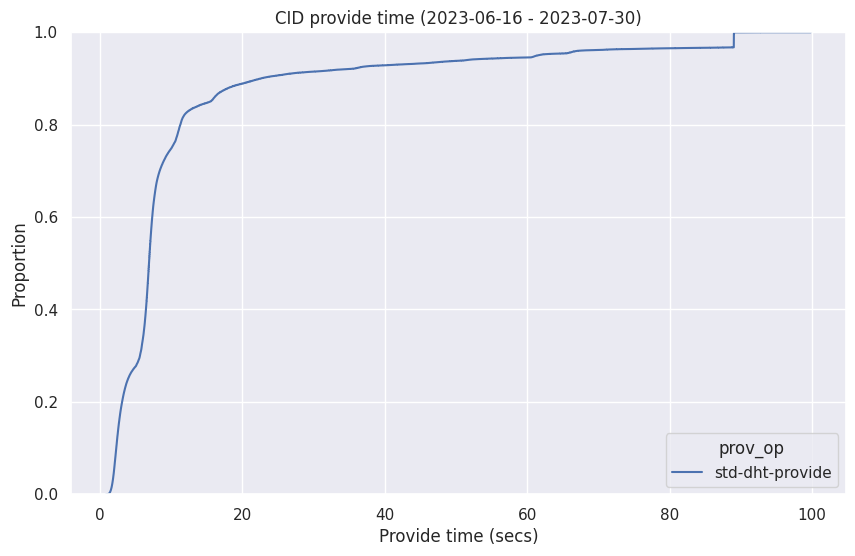

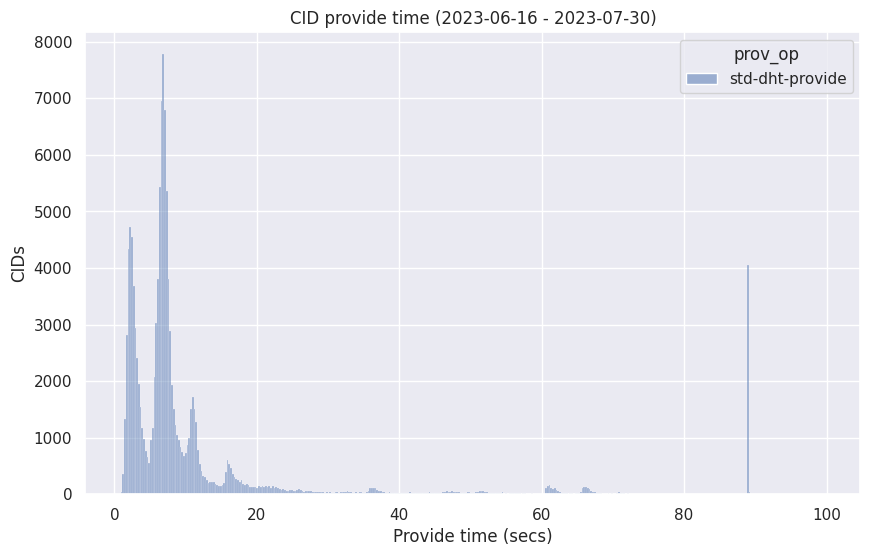

In [12]:
    # Provide Time check
## SQL Query
query = f"""
    SELECT
        prov_op,
        provide_time_ms
    FROM cid_info
    WHERE
        pub_time>='{START_DATE}' and pub_time<='{FINISH_DATE}'
    ORDER BY prov_op ASC, prov_op DESC;
"""

df = pd.read_sql_query(sa.text(query), con)
df['provide_time_s'] = df['provide_time_ms'] / 1000.0
display(df)

## Display the CDF of the Provide Operation
sns.set()
plt.figure(figsize=FIG_SIZE)
g = sns.ecdfplot(x='provide_time_s', hue='prov_op', data=df)
g.set(xlabel='Provide time (secs)')
g.set(title=f'CID provide time ({START_DATE.date()} - {FINISH_DATE.date()})')
plt.savefig(FIGS_FOLDER+'cdf_provide_time.png')
percentiles=df.groupby('prov_op').quantile([0.9, 0.5, 0.01])
display(percentiles)

## Display the histogram of the CDF

sns.set()
plt.figure(figsize=FIG_SIZE)
g = sns.histplot(x='provide_time_s', hue='prov_op', data=df)
g.set(xlabel='Provide time (secs)', ylabel='CIDs')
g.set(title=f'CID provide time ({START_DATE.date()} - {FINISH_DATE.date()})')
plt.savefig(FIGS_FOLDER+'histogram_provide_time.png')


In [1]:
# Display the Client Diversity of the IPFS CID PR Holders
query = f"""
SELECT
    t.cid_hash,
    peer_info.client,
    count(peer_info.client) as pr_holders
FROM (
    SELECT
        pr_holders.cid_hash,
        pr_holders.peer_id,
        pub_time
    FROM pr_holders
    JOIN cid_info ON pr_holders.cid_hash = cid_info.cid_hash
    WHERE
        pub_time >= '{START_DATE}' and
        pub_time <= '{FINISH_DATE}'
) as t
JOIN peer_info ON t.peer_id = peer_info.peer_id
GROUP BY t.cid_hash, peer_info.client
ORDER BY t.cid_hash
"""

df = pd.read_sql_query(sa.text(query), con)
print(df.client.unique())
# Get the PR holder's distribution
df_clients = df.pivot(index='cid_hash', columns='client')
df_clients = df_clients.reset_index("cid_hash")
df_clients = df_clients.fillna(0)
display(df_clients.pr_holders)
sns.set()
plt.figure(figsize=(10,6))
g = sns.boxplot(data=df_clients.pr_holders)
g.set(xlabel=None, ylabel='DHT Servers', title=f'Client diversity among PR Holders ({START_DATE.date()} to {FINISH_DATE.date()})')


NameError: name 'START_DATE' is not defined

,client,peer_id
0,Others,13603
1,go-ipfs,5142
2,hydra-booster,1
3,kubo,32502
4,rust-client,2
5,storm,732


          client  peer_id          %
0         Others    13603  26.168674
1        go-ipfs     5142   9.891886
2  hydra-booster        1   0.001924
3           kubo    32502  62.525490
4    rust-client        2   0.003847
5          storm      732   1.408180


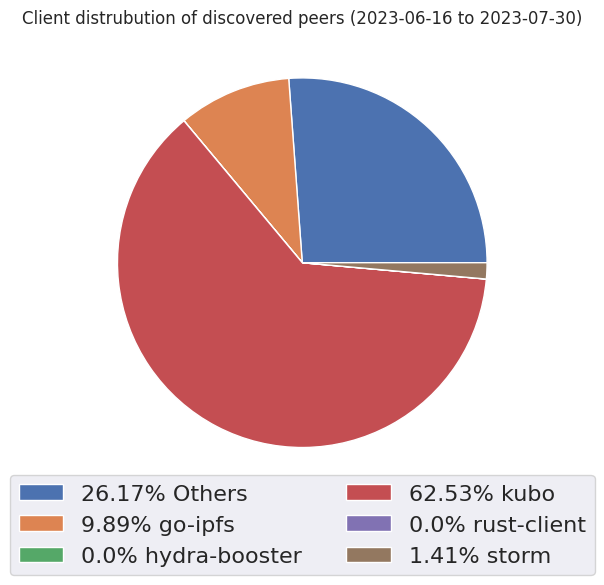

In [14]:
query = f"""
SELECT
    DISTINCT(peer_info.peer_id),
    peer_info.client
FROM (
    SELECT
        pr_holders.cid_hash,
        pr_holders.peer_id,
        pub_time
    FROM pr_holders
    JOIN cid_info ON pr_holders.cid_hash = cid_info.cid_hash
    WHERE
        pub_time >= '{START_DATE}' and
        pub_time <= '{FINISH_DATE}'
) as t
JOIN peer_info ON t.peer_id = peer_info.peer_id
"""

df = pd.read_sql_query(sa.text(query), con)
df_clients = df.groupby('client').count()
df_clients = df_clients.reset_index()
display(df_clients)



# Get total number of peers contacted
total = df_clients["peer_id"].sum()

# get the percentage of each client
df_clients["%"] = (df_clients["peer_id"] * 100) / total
print(df_clients)

# compose labels
labels = []
for i, row in df_clients.iterrows():
    r = f'{round(row["%"], 2)}% {row["client"]}'
    labels.append(r)

sns.set()
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(df_clients['%'], wedgeprops=dict(width=1))
ax.legend(wedges, labels, loc="lower center", bbox_to_anchor=(0.5, -0.20, 0, 0.5), prop={'size': 16}, ncol=2)
plt.title(f"Client distrubution of discovered peers ({START_DATE.date()} to {FINISH_DATE.date()})")
plt.show()


In [15]:
engine.dispose()